In [1]:
import sys
sys.path.append("..")

In [2]:
from src.expectation import Expectation
from src.fidelity import Fidelity

from src.gradients import ExpectationParameterShift, FidelityParameterShift
from src.gradients import ExpectationReverse, FidelityReverse

from experiments.models.heisenline import get_model
from src.realdual import DualRTE

In [3]:
import matplotlib.pyplot as plt

In [32]:
import numpy as np

data = np.load("../ising.npy", allow_pickle=True).item()

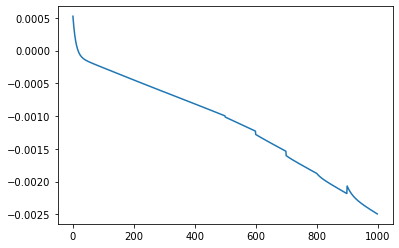

In [33]:
plt.plot(sum(data["losses"][:10], []))

In [34]:
d2 = np.load("../ising_long.npy", allow_pickle=True).item()

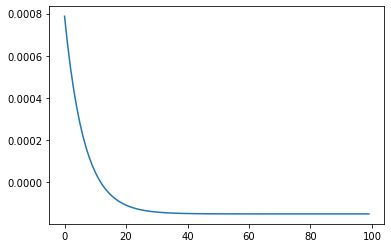

In [35]:
plt.plot(d2["losses"][0])

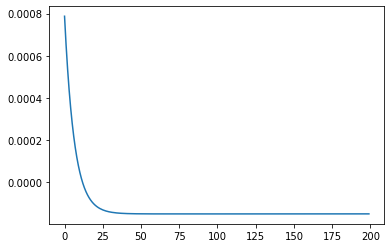

In [36]:
plt.plot(sum(d2["losses"][:10], []))

In [9]:
# pylint: disable=import-error, no-name-in-module
import numpy as np
import logging
import coloredlogs
from dataclasses import asdict

from qiskit.circuit.library import TwoLocal
from qiskit.opflow import PauliSumOp, AerPauliExpectation
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp

from src.expectation import Expectation
from src.fidelity import Fidelity

from src.gradients import ExpectationReverse, FidelityReverse
from src.optimizers import GradientDescent
from src.realdual import DualRTE


reps = 1
# dirname = "data/heisen2/lrel1e1/sv/--_gd100.npy"
dirname = "ising_long.npy"
filenames = [dirname]
# filenames = [f"{dirname}/{i}.npy" for i in range(1, reps + 1)]
# filenames = ["data/heisen3/lr1e3/spsa_it100_b1/sv_xi1.npy"]

J = 1 / 4
h = 1
hamiltonian = PauliSumOp.from_list([("ZZI", J), ("IZZ", J), ("XII", h), ("IXI", h), ("IIX", h)])
magn = PauliSumOp.from_list([("ZII", 1 / 3), ("IZI", 1 / 3), ("IIZ", 1 / 3)])

circuit = TwoLocal(3, rotation_blocks="rx", entanglement_blocks="rzz", reps=1)
initial_parameters = np.zeros(circuit.num_parameters)

print(circuit.decompose().draw())

final_time = 0.02
timestep = 0.01

backend = AerSimulator(method="statevector")
expectation_converter = AerPauliExpectation()
shots = None
expectation_gradient = ExpectationReverse()
fidelity_gradient = FidelityReverse()

expectation = Expectation(backend, expectation_converter, shots=shots)
fidelity = Fidelity(backend, expectation_converter, shots=shots)


opt = GradientDescent(maxiter=10_000, learning_rate=0.2, blocking=False, losstol=1e-6, gradtol=0)
# opt = SPSA(maxiter=100, learning_rate=0.1, perturbation=0.1, batch_size=1, averaging=1)

# algo = VarQITE(circuit, initial_parameters, backend)
algo = DualRTE(
    circuit,
    initial_parameters,
    expectation,
    fidelity,
    expectation_gradient,
    fidelity_gradient,
    norm_factor=0,
    optimizer=opt,
    warmstart=True,
    timestep_normalization=True,
)

     ┌──────────┐                      ┌──────────┐            
q_0: ┤ Rx(θ[0]) ├─■──────────■─────────┤ Rx(θ[6]) ├────────────
     ├──────────┤ │ZZ(θ[3])  │         └──────────┘┌──────────┐
q_1: ┤ Rx(θ[1]) ├─■──────────┼──────────■──────────┤ Rx(θ[7]) ├
     ├──────────┤            │ZZ(θ[4])  │ZZ(θ[5])  ├──────────┤
q_2: ┤ Rx(θ[2]) ├────────────■──────────■──────────┤ Rx(θ[8]) ├
     └──────────┘                                  └──────────┘


In [10]:
algo._sync_primitives(hamiltonian)
loss = algo.get_loss_and_gradient(timestep, initial_parameters)

[ 0.5  0.5  0.5 -0.  -0.  -0.   0.5  0.5  0.5]


In [11]:
loss(initial_parameters)

(0.0, array([0.005, 0.005, 0.005, 0.   , 0.   , 0.   , 0.005, 0.005, 0.005]))

In [12]:
# direction = np.ones(circuit.num_parameters)
direction = np.random.choice([1, -1], circuit.num_parameters)
eps = np.linspace(-0.2, 0.2, 200)
cut = [loss(eps_i * direction)[0] for eps_i in eps]

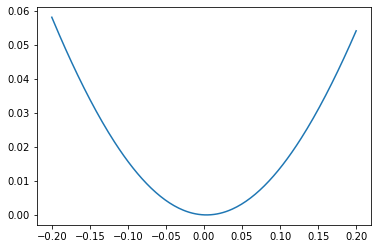

In [13]:
plt.plot(eps, cut)

In [14]:
theta = initial_parameters

In [15]:
thetas, values, gradients = [theta], [], []
eta = 0.1

In [16]:
N = 10

In [17]:
for _ in range(N):
    val, grad = loss(thetas[-1])
    values.append(val)
    gradients.append(grad)
    print(f"{val} {np.linalg.norm(grad)}", end="\r")#, grad)
    thetas.append(thetas[-1] - eta * grad)

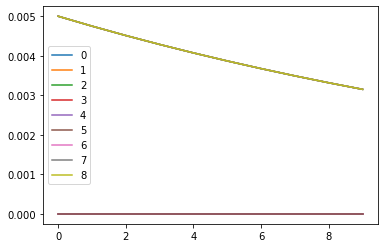

In [18]:
for dim in range(circuit.num_parameters):
    plt.plot(np.asarray(gradients)[:, dim], label=f"{dim}")
    
plt.legend()

In [19]:
np.mean(np.asarray(gradients)[100:, :], axis=0)

/Users/jul/opt/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jul/opt/miniconda3/envs/py10/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


array([nan, nan, nan, nan, nan, nan, nan, nan, nan])

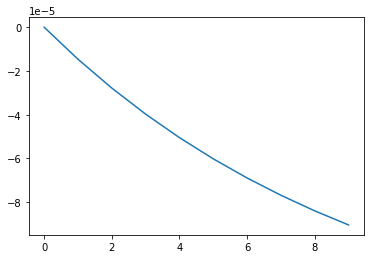

In [20]:
plt.plot(values)

In [21]:
direction = np.random.choice([1, -1], circuit.num_parameters)
loss(0.1 * direction)

(0.006032405658915495,
 array([ 5.49009853e-03,  4.99754543e-03,  5.46624113e-02,  4.87643960e-04,
         4.90086234e-04, -3.46944695e-18,  4.50990147e-03,  5.00245457e-03,
         5.46624113e-02]))

In [22]:
theta = np.zeros(9)
theta[3] = 100000
loss(theta)

(0.0, array([0.005, 0.005, 0.005, 0.   , 0.   , 0.   , 0.005, 0.005, 0.005]))

In [23]:
circuit.decompose().draw()

┌──────────┐                      ┌──────────┐            
q_0: ┤ Rx(θ[0]) ├─■──────────■─────────┤ Rx(θ[6]) ├────────────
     ├──────────┤ │ZZ(θ[3])  │         └──────────┘┌──────────┐
q_1: ┤ Rx(θ[1]) ├─■──────────┼──────────■──────────┤ Rx(θ[7]) ├
     ├──────────┤            │ZZ(θ[4])  │ZZ(θ[5])  ├──────────┤
q_2: ┤ Rx(θ[2]) ├────────────■──────────■──────────┤ Rx(θ[8]) ├
     └──────────┘                                  └──────────┘

In [24]:
from qiskit.primitives import Estimator
from qiskit.algorithms.gradients import LinCombEstimatorGradient
from qiskit.algorithms.gradients.lin_comb_estimator_gradient import DerivativeType

In [25]:
hamiltonian = hamiltonian.to_matrix_op().primitive

In [26]:
est = Estimator()
grad = LinCombEstimatorGradient(est, derivative_type=DerivativeType.COMPLEX)
iden = SparsePauliOp(["I" * circuit.num_qubits])

In [27]:
grads = grad.run(2 * [circuit], [hamiltonian, iden], 2 * [initial_parameters]).result()
E = est.run([circuit], [hamiltonian], [initial_parameters]).result().values[0]

In [28]:
dE = grads.gradients[0]
dPsi = grads.gradients[1]

In [29]:
dE - E * dPsi

array([0.-1.j, 0.-1.j, 0.-1.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j, 0.-1.j,
       0.-1.j])

In [30]:
from src.gradients import ExpectationReverse, FidelityReverse

In [31]:
exp = Expectation(None, None)

TypeError: '<=' not supported between instances of 'NoneType' and 'int'

In [ ]:
rev = ExpectationReverse(partial=True)
rev.expectation

In [ ]:
from surfer.gradient import ReverseGradient

In [ ]:
rev = ReverseGradient(partial_gradient=True)
de = rev.compute(hamiltonian, circuit, initial_parameters)
dpsi = rev.compute(iden, circuit, initial_parameters)

In [ ]:
dE / 2

In [ ]:
dPsi / 2

In [ ]:
de

In [ ]:
dpsi

In [ ]:
dE / 2 - E * dPsi / 2

In [ ]:
de - E * dpsi